## Import libs

In [2]:
%cd ..

/home/sasha/effective-inference


In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch


#from progressbar import progressbar
from tqdm.auto import tqdm
from collections import defaultdict
from utils.prepare_dataset import load_datasets, cut_datasets

## Define hyperparams

In [7]:
# Define datasets
#['mrpc', 'sst2', 'cola', 'rte', 'qnli']
glue_classification = {'mrpc': ['sentence1', 'sentence2']} #, 'sst2':  ['sentence']}
superglue_classification = {'wic': ['sentence1', 'sentence2']}
all_classification = {'glue': glue_classification, 'superglue': superglue_classification}

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=1024)
model = AutoModel.from_pretrained(model_name)
model.eval()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'

model.to(device)
DEBUG_FLAG = True
CUT_SIZE = None if not DEBUG_FLAG else 100

## Load datasets

In [8]:
glue_datasets = load_datasets('glue', list(glue_classification), CUT_SIZE)
superglue_datasets = load_datasets('super_glue', list(superglue_classification), CUT_SIZE)

all_datasets = {'glue': glue_datasets, 'superglue': superglue_datasets}

## Collect dataset for layers and heads

In [9]:
import numpy as np
import json
import h5py
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


In [10]:
def get_dataset_for_regression(prob_of_take=0.13, layer=0, head_num=0):
    X_train, y_train = [], []
    X_test, y_test = [], []
    length = len(glue_datasets['mrpc']['train']) if not CUT_SIZE else CUT_SIZE
    for ex_idx, ex in tqdm(enumerate(glue_datasets['mrpc']['train'])):
        encoded_inputs = tokenizer.encode(
                            ex['sentence1'],
                            ex['sentence2'],
                            truncation=True,
                            return_tensors='pt'
                        )
        special_symbols = (encoded_inputs[0] < 103).nonzero().squeeze()
        with h5py.File(f'notebooks/mrpc/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'r') as f:

            current_hidden_states = f['current_hidden_states'][()]
            next_hidden_states = f['next_hidden_states'][()]
            attentions = f['attentions'][()]

            len_of_seq = attentions.shape[0]
            for from_ in range(len_of_seq):
                for to_ in range(len_of_seq):
                    if np.random.choice([0, 1], size=1, p=[1-prob_of_take, prob_of_take])[0] > 0.5:
                        feature_vector = []
                        # (pos form, pos to, is_from_special_token, is_to_special_token,
                        # len_of_seq, rel_position_from, rel_position_to, rev_pos_from, rev_pos_to, to_emb)


                        feature_vector.append(from_) # from_ pos
                        feature_vector.append(to_) # to_ pos

                        is_from_special_token = int(from_ in special_symbols)
                        is_to_special_token = int(to_ in special_symbols)
                        feature_vector.append(is_from_special_token)
                        feature_vector.append(is_to_special_token)

                        feature_vector.append(len_of_seq)
                        feature_vector.append(1/len_of_seq)
                        feature_vector.append(from_/len_of_seq)
                        feature_vector.append(to_/len_of_seq)
                        feature_vector.append(len_of_seq - from_)
                        feature_vector.append(len_of_seq - to_)
                        feature_vector += list(current_hidden_states[to_])


                        if ex_idx < length*0.85:
                            X_train.append(feature_vector)
                            y_train.append(attentions[from_, to_])
                        else:
                            X_test.append(feature_vector)
                            y_test.append(attentions[from_, to_])
    return X_train, y_train, X_test, y_test

In [11]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statistics import mean

def learn_linear(model, y_scaler, reverse_scaler, X_train, y_train, X_test, y_test, feature_names, num_examples = 5):
    # y_scaler = StandardScaler()
    y_train_scaled = y_scaler(y_train) # .reshape(-1, 1)
    y_test_scaled = y_scaler(y_test) # .reshape(-1, 1)

    print('Y train mean:', np.mean(y_train_scaled))
    print('Y test mean:', np.mean(y_test_scaled))

    print('Mean cross val R2:', np.mean(cross_val_score(model, X_train, y_train_scaled, cv=5, scoring='r2')))

    model.fit(X_train, y_train_scaled)
    preds_scaled = model.predict(X_test)
    preds = reverse_scaler(preds_scaled)

    r2_score_test = r2_score(y_test, preds)
    print('Test R2:', r2_score_test)
    print('\nPredictions:')
    samples = np.random.choice(len(X_test), size=num_examples, replace=False)
    for i in samples:
        print(f'Pred = {preds_scaled[i]} / {preds[i]} and target = {y_test_scaled[i]} / {y_test[i]}')

    fig, ax = plt.subplots(1, 3, figsize = (18, 5))
    plt.subplot(1, 3, 1)
    sns.histplot([y_test_scaled, preds_scaled])
    plt.title('Target  distribution')
    plt.legend( loc='upper left', labels=['Test', 'Pred'])
    
    

    # Scatter plot of predictions vs. actual values
    ax[1].scatter(y_test, preds)
    ax[1].set_xlabel('Actual Values')
    ax[1].set_ylabel('Predictions')
    ax[1].set_title('Predictions vs. Actual Values')

    feature_importance = [abs(el) for el in model[1].coef_]
    most_important_features = np.argsort(feature_importance)[:14]
    fnames = np.array(feature_names)[most_important_features]
    fimport = np.array(feature_importance)[most_important_features]
    #print(fnames, fimport)
    plt.subplot(1, 3, 3)
    ax[2].bar(fnames, fimport)
    ax[2].set_xlabel('Features')
    ax[2].set_ylabel('Importance')
    ax[2].set_title('Feature Importance')
    ax[2].set_xticks(fnames)
    ax[2].set_xticklabels(fnames, rotation=90)
    
    plt.show()
    return model

In [12]:
def learn_tree(model, y_scaler, reverse_scaler, X_train, y_train, X_test, y_test, feature_names, num_examples = 5):
    # y_scaler = StandardScaler()
    y_train_scaled = y_scaler(y_train) # .reshape(-1, 1)
    y_test_scaled = y_scaler(y_test) # .reshape(-1, 1)

    print('Y train mean:', np.mean(y_train_scaled))
    print('Y test mean:', np.mean(y_test_scaled))

    #print('Mean cross val R2:', np.mean(cross_val_score(model, X_train, y_train_scaled, cv=5, scoring='r2')))

    model.fit(X_train, y_train_scaled)
    preds_scaled = model.predict(X_test)
    preds = reverse_scaler(preds_scaled)

    r2_score_test = r2_score(y_test, preds)
    print('Test R2:', r2_score_test)
    print('\nPredictions:')
    samples = np.random.choice(len(X_test), size=num_examples, replace=False)
    for i in samples:
        print(f'Pred = {preds_scaled[i]} / {preds[i]} and target = {y_test_scaled[i]} / {y_test[i]}')

    fig, ax = plt.subplots(1, 3, figsize = (18, 5))
    plt.subplot(1, 3, 1)
    sns.histplot([y_test_scaled, preds_scaled])
    plt.title('Target  distribution')
    plt.legend( loc='upper left', labels=['Test', 'Pred'])
    
    
    plt.subplot(1, 3, 2)
    # Scatter plot of predictions vs. actual values
    ax[1].scatter(y_test, preds)
    ax[1].set_xlabel('Actual Values')
    ax[1].set_ylabel('Predictions')
    ax[1].set_title('Predictions vs. Actual Values')

    feature_importance = model.feature_importances_
    most_important_features = np.argsort(feature_importance)[:14]
    #print(most_important_features, feature_names, feature_importance)
    fnames = np.array(feature_names)[most_important_features]
    fimport = np.array(feature_importance)[most_important_features]
    #print(fnames, fimport)
    ax[2].bar(fnames, fimport)
    ax[2].set_xlabel('Features')
    ax[2].set_ylabel('Importance')
    ax[2].set_title('Feature Importance')
    ax[2].set_xticklabels(fnames, rotation=90)

    plt.tight_layout()
    plt.show()

    # SHAP FEATURE IMPORTANCE
    #try:
    #    explainer = shap.Explainer(model, X_test, feature_names=feature_names)
    #    shap_values = explainer(X_test)

    #    shap.plots.bar(shap_values.abs.sum(0), show_data=None, show=False)
    #    plt.title(f'SHAP Feature Importance')
    #    plt.show()
    #except:
    #    pass
    return model

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

pipe_linear = Pipeline([('scaler', StandardScaler()), ('model', Ridge())])
pipe_tree =  Pipeline([('scaler', StandardScaler()), ('model', DecisionTreeRegressor(min_samples_split=20))])
pipe_forest = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators=100))])

In [14]:
id_scaler = lambda x: [el for el in x]
log_scaler = lambda x: np.log(x * 1000 + 1)
log_reverse = lambda x: (np.exp(x) - 1) / 1000

## Layer 0

In [19]:
# X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=0, head_num=0)
# X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
with h5py.File(f'notebooks/data/mrpc/layer_0/{3}.hdf5', 'r') as f:
                X_train = f['X_train'][()]
                y_train = f['y_train'][()]
                X_test = f['X_test'][()]
                y_test = f['y_test'][()]       
X_train.shape, X_test.shape

((224251, 779), (11803, 779))

In [22]:
## ADD ALL TOGETHER
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4],
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) # + [f'emb_neuron_{i}' for i in range(10,778)]
lst_features = [0, 1, 4, 5, 6, 7, 8, 9]

feature_names_no_poly = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

# learn(pipe_linear, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
# print('Success')

Y train mean: -5.2411304
Y test mean: -5.2886014
Mean cross val R2: -0.006359099946223123
Test R2: 0.007878586964342293

Predictions:
Pred = -5.0555281920455295 / -5.0555281920455295 and target = -3.8364038467407227 / -3.8364038467407227
Pred = -5.250439679624198 / -5.250439679624198 and target = -3.1152005195617676 / -3.1152005195617676
Pred = -5.130601432437912 / -5.130601432437912 and target = -3.9695773124694824 / -3.9695773124694824
Pred = -5.287992736403973 / -5.287992736403973 and target = -4.625792026519775 / -4.625792026519775
Pred = -5.229483356883178 / -5.229483356883178 and target = -9.602945327758789 / -9.602945327758789


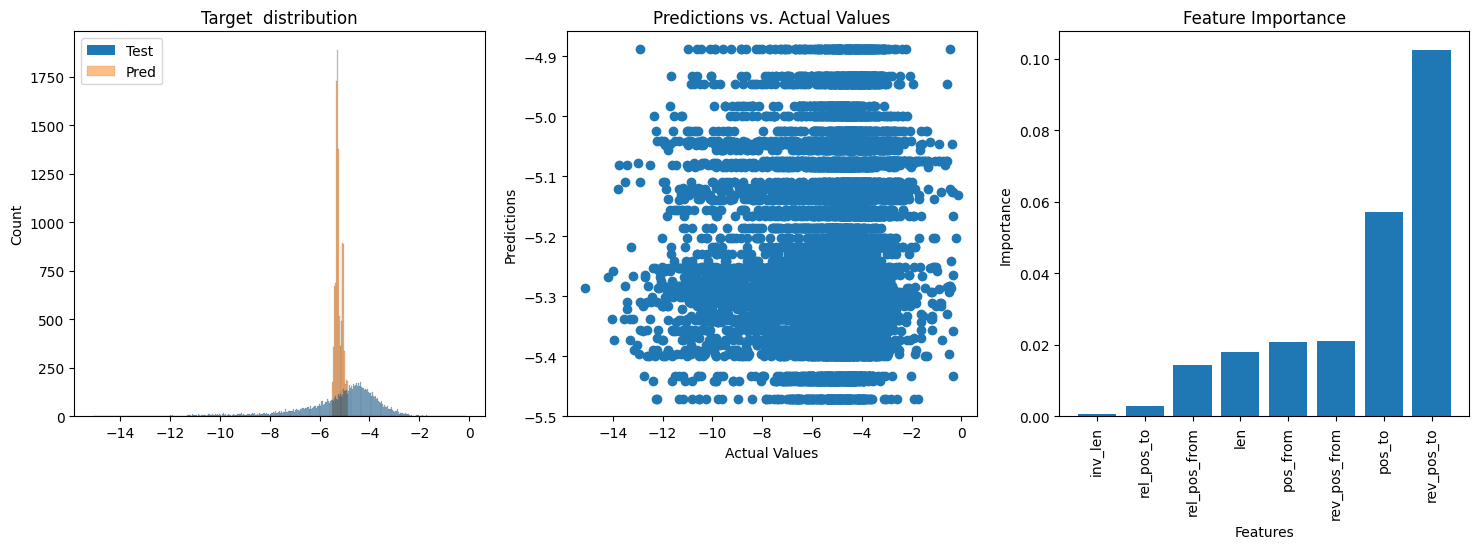

Success


In [23]:
learn_linear(pipe_linear, id_scaler, id_scaler,  X_train[:, lst_features], y_train, 
           X_test[:, lst_features], y_test, feature_names)
print('Success')

Y train mean: 0.0178955
Y test mean: 0.017956808
Test R2: -0.7063486044706642

Predictions:
Pred = 0.01501288078725338 / 0.01501288078725338 and target = 0.01696748286485672 / 0.01696748286485672
Pred = 0.012798161245882511 / 0.012798161245882511 and target = 0.008726043626666069 / 0.008726043626666069
Pred = 0.08947369456291199 / 0.08947369456291199 and target = 0.022238677367568016 / 0.022238677367568016
Pred = 0.008772372733801603 / 0.008772372733801603 and target = 0.007754014804959297 / 0.007754014804959297
Pred = 0.036713022738695145 / 0.036713022738695145 and target = 0.030168132856488228 / 0.030168132856488228


/tmp/ipykernel_12548/3073491818.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(fnames, rotation=90)


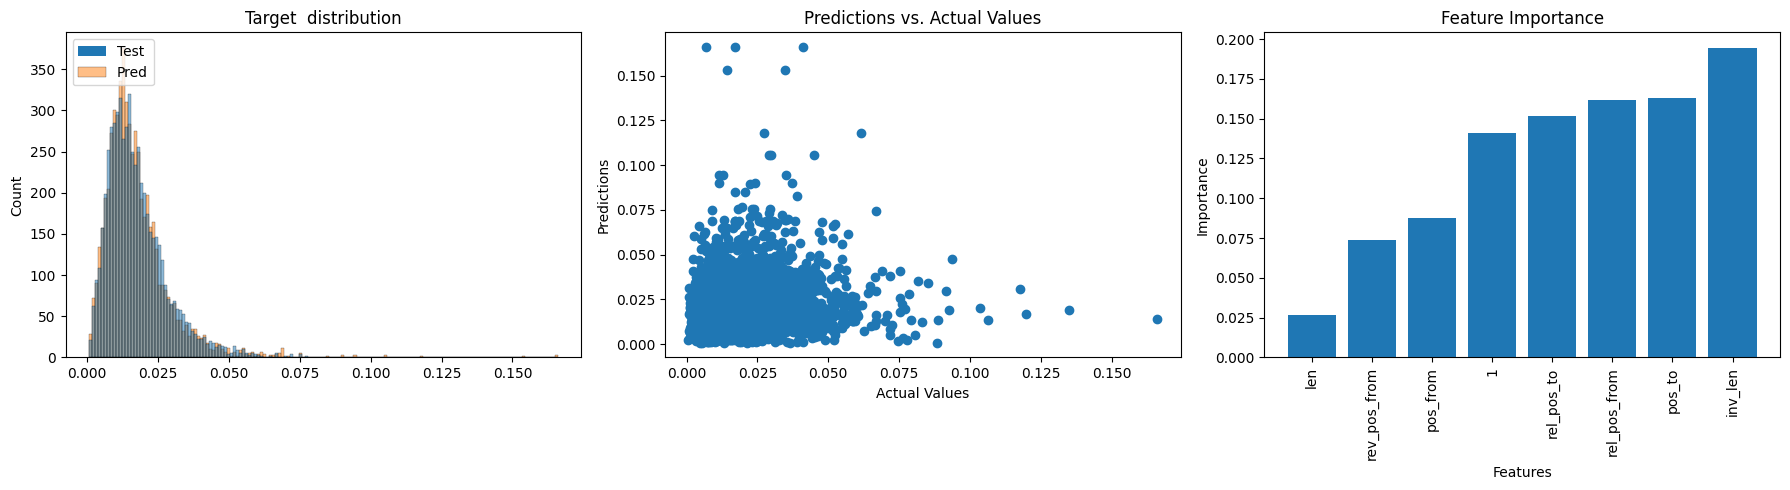

Success


In [14]:
learn_tree(DecisionTreeRegressor(), 
           id_scaler, id_scaler, X_train[:, lst_features], y_train, 
           X_test[:, lst_features], y_test, feature_names)
print('Success')

Y train mean: 0.0178955
Y test mean: 0.017956808
Test R2: 0.28836778509886674

Predictions:
Pred = 0.024507700195536018 / 0.024507700195536018 and target = 0.025873692706227303 / 0.025873692706227303
Pred = 0.009300270599778742 / 0.009300270599778742 and target = 0.014823558740317822 / 0.014823558740317822
Pred = 0.017695798245258628 / 0.017695798245258628 and target = 0.02543543465435505 / 0.02543543465435505
Pred = 0.019564302656799554 / 0.019564302656799554 and target = 0.02024136111140251 / 0.02024136111140251
Pred = 0.016384733314625918 / 0.016384733314625918 and target = 0.006078202277421951 / 0.006078202277421951


/tmp/ipykernel_12548/3073491818.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(fnames, rotation=90)


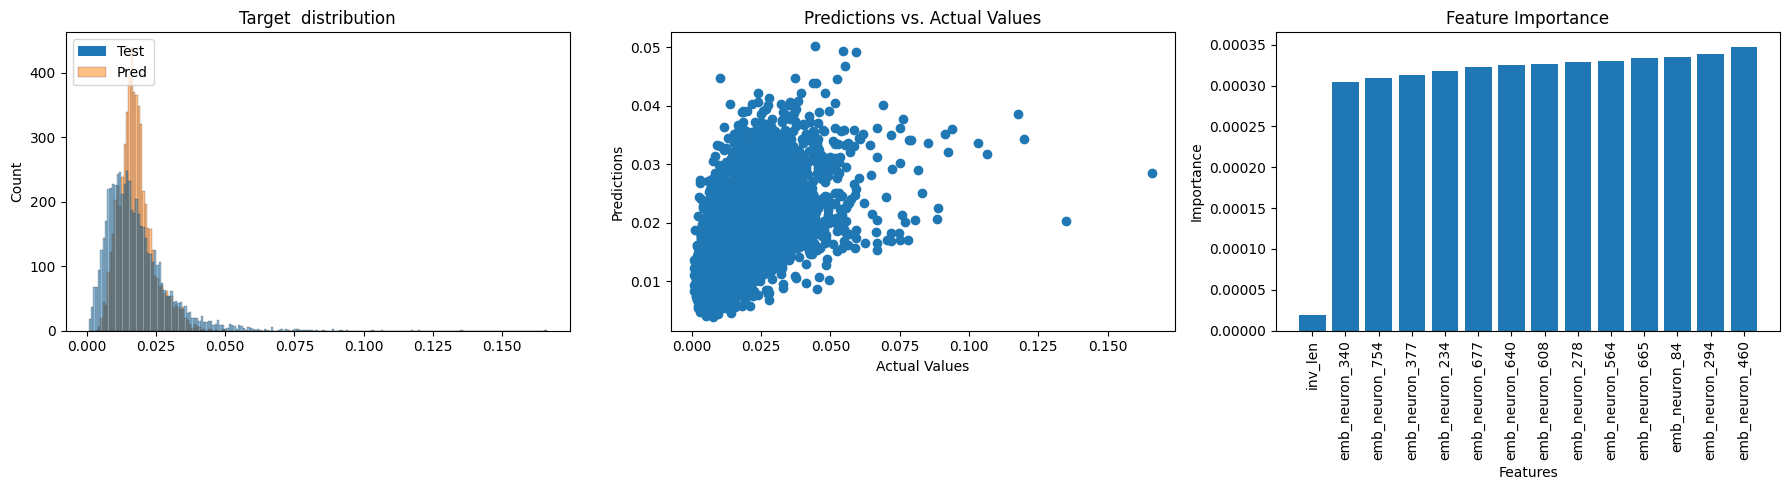

Success


In [15]:
learn_tree(RandomForestRegressor(n_estimators=100), id_scaler, id_scaler, X_train[:], y_train, 
           X_test[:], y_test, feature_names_no_poly)
print('Success')

## Layer 2

In [12]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=2, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

100it [00:15,  6.44it/s]


((32291, 778), (5728, 778))

In [14]:
## ADD ALL TOGETHER
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4],
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) # + [f'emb_neuron_{i}' for i in range(10,778)]
lst_features = [0, 1, 4, 5, 6, 7, 8, 9]

feature_names_no_poly = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)

feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]
print(len(feature_names))
print(X_train_poly.shape)

# learn(pipe_linear, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
# print('Success')

1263
(32291, 1263)


Y train mean: 0.017636146
Y test mean: 0.0153308455
Mean cross val R2: -0.02236390623285116
Test R2: -0.019462825647229343

Predictions:
Pred = 0.01913254219790997 / 0.01913254219790997 and target = 2.2140004673348868e-13 / 2.2140004673348868e-13
Pred = -0.016247348066828073 / -0.016247348066828073 and target = 3.0524743124260567e-06 / 3.0524743124260567e-06
Pred = 0.025480275165628688 / 0.025480275165628688 and target = 2.2342147663195755e-12 / 2.2342147663195755e-12
Pred = 0.06940679257185978 / 0.06940679257185978 and target = 4.096066541503518e-11 / 4.096066541503518e-11
Pred = 0.016588639407725154 / 0.016588639407725154 and target = 8.164516174247183e-08 / 8.164516174247183e-08


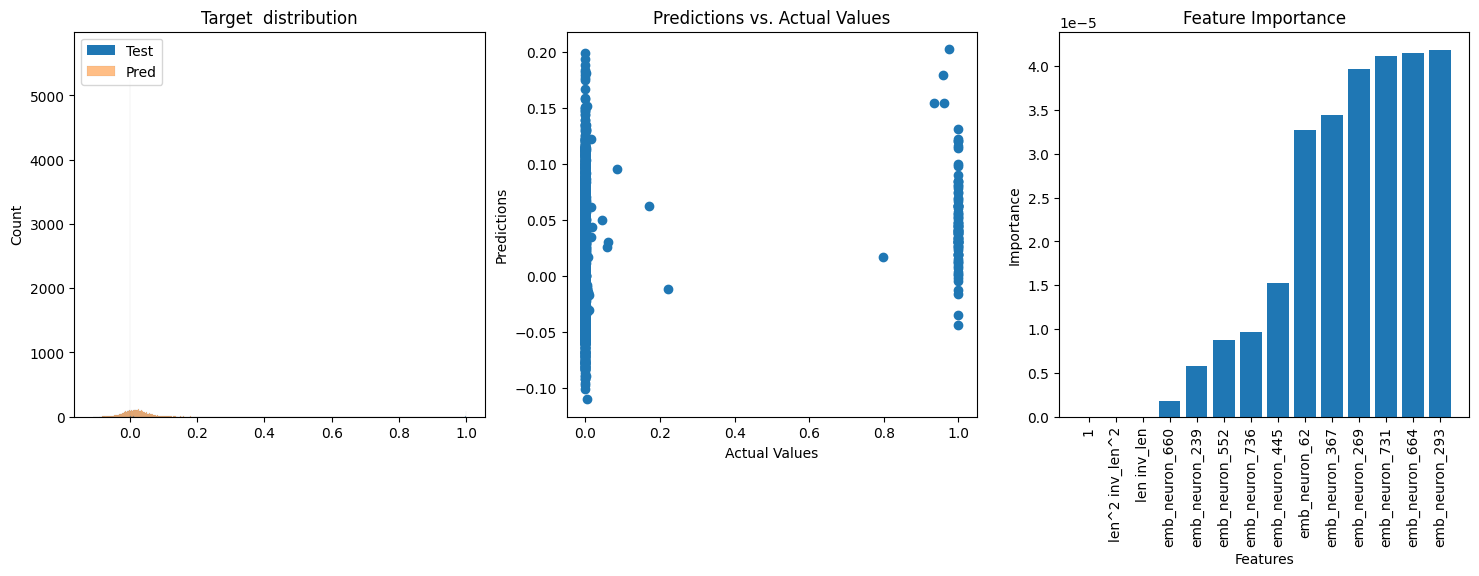

Success


In [22]:
learn_linear(pipe_linear, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

In [ ]:
learn_tree(DecisionTreeRegressor(), 
           id_scaler, id_scaler, X_train[:, lst_features], y_train, 
           X_test[:, lst_features], y_test, feature_names)
print('Success')

In [ ]:
learn_tree(RandomForestRegressor(n_estimators=100), id_scaler, id_scaler, X_train[:, lst_features], y_train, 
           X_test[:, lst_features], y_test, feature_names_no_poly)
print('Success')

## Layer 5

In [ ]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=5, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

In [ ]:
## ADD ALL TOGETHER
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4],
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) # + [f'emb_neuron_{i}' for i in range(10,778)]
lst_features = [0, 1, 4, 5, 6, 7, 8, 9]

feature_names_no_poly = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)

feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]
print(len(feature_names))
print(X_train_poly.shape)

# learn(pipe_linear, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
# print('Success')

In [ ]:
learn_linear(pipe_linear, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

In [ ]:
learn_tree(RandomForestRegressor(n_estimators=100), id_scaler, id_scaler, X_train[:, lst_features], y_train, 
           X_test[:, lst_features], y_test, feature_names_no_poly)
print('Success')

## Layer 8

In [ ]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=8, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

In [ ]:
## ADD ALL TOGETHER
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4],
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) # + [f'emb_neuron_{i}' for i in range(10,778)]
lst_features = [0, 1, 4, 5, 6, 7, 8, 9]

feature_names_no_poly = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)

feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]
print(len(feature_names))
print(X_train_poly.shape)

# learn(pipe_linear, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
# print('Success')

In [ ]:
learn_linear(pipe_linear, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

In [ ]:
learn_tree(DecisionTreeRegressor(min_samples_split=20), 
           id_scaler, id_scaler, X_train[:, lst_features], y_train, 
           X_test[:, lst_features], y_test, list(feature_names))
print('Success')

In [ ]:
learn_tree(RandomForestRegressor(n_estimators=100), id_scaler, id_scaler, X_train, y_train, 
           X_test, y_test, feature_names_no_poly)
print('Success')

## Layer 11

In [ ]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=11, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

In [ ]:
## ADD ALL TOGETHER
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4],
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) # + [f'emb_neuron_{i}' for i in range(10,778)]
lst_features = [0, 1, 4, 5, 6, 7, 8, 9]

feature_names_no_poly = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)

feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]
print(len(feature_names))
print(X_train_poly.shape)

# learn(pipe_linear, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
# print('Success')

In [ ]:
learn_linear(pipe_linear, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

In [ ]:
learn_tree(RandomForestRegressor(n_estimators=100), id_scaler, id_scaler, X_train[:, lst_features], y_train, 
           X_test[:, lst_features], y_test, feature_names_no_poly)
print('Success')